Using kernel `conda_pytorch_latest_p36`

In [9]:
# !pip install fastai

In [1]:
classes = [
    'Agricolture',
    'Cross',
    'Education',
    'Food Security',
    'Health',
    'Livelihoods',
    'Logistics',
    'Nutrition',
    'Protection',
    'Shelter',
    'Wash'
]

In [2]:
import torch

In [3]:
from pathlib import Path
import os
import random
import pickle

In [4]:
from fastai.text.all import *
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [5]:
data = Path('data_prep/final_data/en/')
raw = pd.read_csv('data_prep/data/entries_raw.csv')

In [6]:
train = pd.read_csv(data / 'sentences_en_train.csv')
test = pd.read_csv(data / 'sentences_en_test.csv')

In [7]:
train

,doc_id,sentence_id,sentence_text,is_relevant,sector_ids
0,51787,38,"Climate Change and Agriculture: Subsistence Farmers Response to Extreme Heat.American Economic Journal: Economic Policy, 13(1), 1-35.",0,[]
1,51787,44,"Bohorquez-Penuela, C., & Otero-Cortes, A (2020).",0,[]
2,51787,45,Blame it on the Rain: The Effects of Weather Shocks on Formal Rural Employment in Colombia.Documento de Trabajo sobre Econom a Regional y Urbana; No.,0,[]
3,51787,49,"Increasing frequency of extreme El Ni o events due to greenhouse warming.Nature climate change, 4(2), 111-116.",0,[]
4,51787,53,What do we learn from the weather?,0,[]
...,...,...,...,...,...
191932,34512,112,"Emergency shelters in India had reportedly been converted to COVID-19 isolation centres, decreasing the capacity for evacuation shelters in affected areas (AA 20/05/2020).",0,[]
191933,34512,116,"In these situations humanitarian operations may have been limited to essential services and slowed down, but not come to a complete stop.",0,[]
191934,34512,120,Governments of EU member states and several African states set up a humanitarian air bridge enabling the transport of humanitarian workers and relief items despite flight suspensions (EC 10/06/2020).,0,[]
191935,34512,124,You can find an overview of all ACAPS resources on COVID-19 here.,0,[]


In [8]:
def process_for_sector(df, sector, train):
    relevant_train = df[df.is_relevant == 1]
    relevant_train.sector_ids = relevant_train.sector_ids.apply(eval)
    relevant_train = relevant_train[relevant_train.sector_ids.apply(len) > 0]
    
    positive_train = relevant_train[relevant_train.sector_ids.apply(lambda x: sector in x)]
    negative_train = relevant_train[relevant_train.sector_ids.apply(lambda x: sector not in x)]

    positive_train.sector_ids = 1
    negative_train.sector_ids = 0
    train_df = pd.concat([positive_train, negative_train])
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    
    train_df['is_valid'] = False if train else True
        
    return train_df

In [58]:
def process_multiclass(df, train):
    relevant_train = df[df.is_relevant == 1]
    relevant_train.sector_ids = relevant_train.sector_ids.apply(eval)
    relevant_train = relevant_train[relevant_train.sector_ids.apply(len) > 0]
    relevant_train.sector_ids = relevant_train.sector_ids.apply(lambda x: ';'.join(classes[i] for i in x))
#     relevant_train.sector_ids = relevant_train.sector_ids.apply(lambda x: [classes[i] for i in x][0])

    
    relevant_train['is_valid'] = False if train else True
    
    return relevant_train
    
    

# Use fastai

In [60]:
train_df = process_multiclass(train, True)
test_df = process_multiclass(test, False)
df = pd.concat([train_df, test_df])

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [19]:
a = train_df.explode('sector_ids')

In [25]:
b = train_df.copy()

In [64]:
weights = torch.Tensor(a.sector_ids.value_counts().values)
weights = weights/weights.sum()
weights = (1/weights).cuda()

In [116]:
weights = weights / weights.sum()

In [118]:
dls = TextDataLoaders.from_df(
    df,
    text_col='sentence_text',
    label_col='sector_ids',
    label_delim=';',
    valid_col='is_valid',
    is_lm = False,    # Mention explicitly that this dataloader is meant for language model
    seq_len = 72,     # Pick a sequence length i.e. how many words to feed through the RNN at once
    bs = 64,     # Specify the batch size for the dataloader
    y_block=MultiCategoryBlock,
)
learn = text_classifier_learner(
    dls, 
    AWD_LSTM, 
    drop_mult=0.5, 
    metrics=[
        accuracy_multi, 
        RecallMulti(thresh=0.35), 
        PrecisionMulti(thresh=0.35), 
        F1ScoreMulti(thresh=0.35), 
        RocAucMulti()
    ]
)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [119]:
learn.loss_func = BCEWithLogitsLossFlat(pos_weight=weights)

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.05754399299621582)

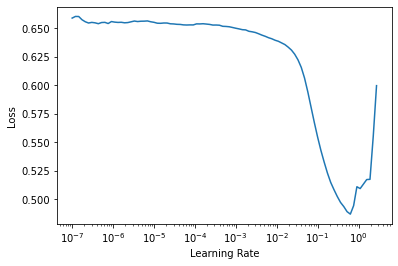

In [120]:
learn.lr_find()

In [121]:
learn.fine_tune(4, 0.06)

epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.047802,0.042935,0.878058,0.038106,0.618167,0.068460,0.808377,00:57


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.039909,0.038371,0.893230,0.196865,0.642016,0.281341,0.866789,02:02
1,0.036703,0.035206,0.906307,0.247074,0.655731,0.346506,0.881460,02:05
2,0.032220,0.034500,0.907777,0.275050,0.749056,0.381553,0.887784,02:05
3,0.029504,0.035353,0.914597,0.322056,0.712782,0.431156,0.890491,02:05


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [94]:
def get_threshold_metrics(preds, targets, num_thresholds):
    thresholds = [x/num_thresholds for x in range(num_thresholds)]

    recalls = []
    precisions = []
    f1_scores = []

    for threshold in thresholds:
        t_preds = (preds.view(-1).numpy() > threshold).astype(int)
        t_targets = targets.view(-1).numpy()
        precisions.append(precision_score(t_targets, t_preds))
        recalls.append(recall_score(t_targets, t_preds))    
        f1_scores.append(f1_score(t_targets, t_preds))        
        
    all_metrics = pd.DataFrame(
        {
            'threshold': thresholds,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores
        }
    ).set_index('threshold', drop=True)

    return all_metrics

In [131]:
def get_best_threshold(learner, num_thresholds=20):
    train_preds, train_targets = learn.get_preds(1)
    train_metrics = get_threshold_metrics(train_preds, train_targets, num_thresholds)
    best_threshold = train_metrics.f1_score.idxmax()
    
    return best_threshold, train_metrics

In [132]:
def get_metrics(preds, targets):
    indexes = []
    recalls = []
    precisions = []
    f1_scores = []
    
    for i, class_ in enumerate(classes):
        class_preds = preds[:, i]
        class_targets = targets[:, i]
        
        indexes.append(class_)
        precisions.append(precision_score(class_targets, class_preds))
        recalls.append(recall_score(class_targets, class_preds))    
        f1_scores.append(f1_score(class_targets, class_preds))        
        
    indexes.append('all')
    precisions.append(precision_score(targets.view(-1), preds.view(-1)))
    recalls.append(recall_score(targets.view(-1), preds.view(-1)))    
    f1_scores.append(f1_score(targets.view(-1), preds.view(-1)))       

    
    all_metrics = pd.DataFrame(
        {
            'class': indexes,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores
        }
    ).set_index('class', drop=True)
    
    return all_metrics

In [133]:
def evaluate(learner, threshold):
    test_preds, test_targets = learn.get_preds(1)
    

In [134]:
best_threshold, train_metrics = get_best_threshold(learn)
print(best_threshold)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.05


In [135]:
train_metrics

,recall,precision,f1_score
threshold,,,
0.00,0.123538,1.000000,0.219908
0.05,0.750328,0.579894,0.654192
0.10,0.828262,0.503165,0.626024
0.15,0.863383,0.470499,0.609080
0.20,0.876761,0.441378,0.587165
0.25,0.892167,0.421119,0.572166
0.30,0.907887,0.399342,0.554696
0.35,0.914724,0.377564,0.534504
0.40,0.920798,0.362117,0.519811


In [127]:
test_preds, test_targets = learn.get_preds(1)
test_discrete_preds = (test_preds > best_threshold).int()
test_discrete_targets = test_targets.int()

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [128]:
multi_label_metrics = get_metrics(test_discrete_preds,test_discrete_targets)

In [129]:
multi_label_metrics

,recall,precision,f1_score
class,,,
Agricolture,0.108696,0.714286,0.188679
Cross,0.103070,0.635135,0.177358
Education,0.580786,0.826087,0.682051
Food Security,0.585242,0.769231,0.664740
Health,0.781746,0.908672,0.840444
Livelihoods,0.449438,0.647773,0.530680
Logistics,0.366906,0.607143,0.457399
Nutrition,0.660870,0.655172,0.658009
Protection,0.661939,0.632054,0.646651


<AxesSubplot:xlabel='class'>

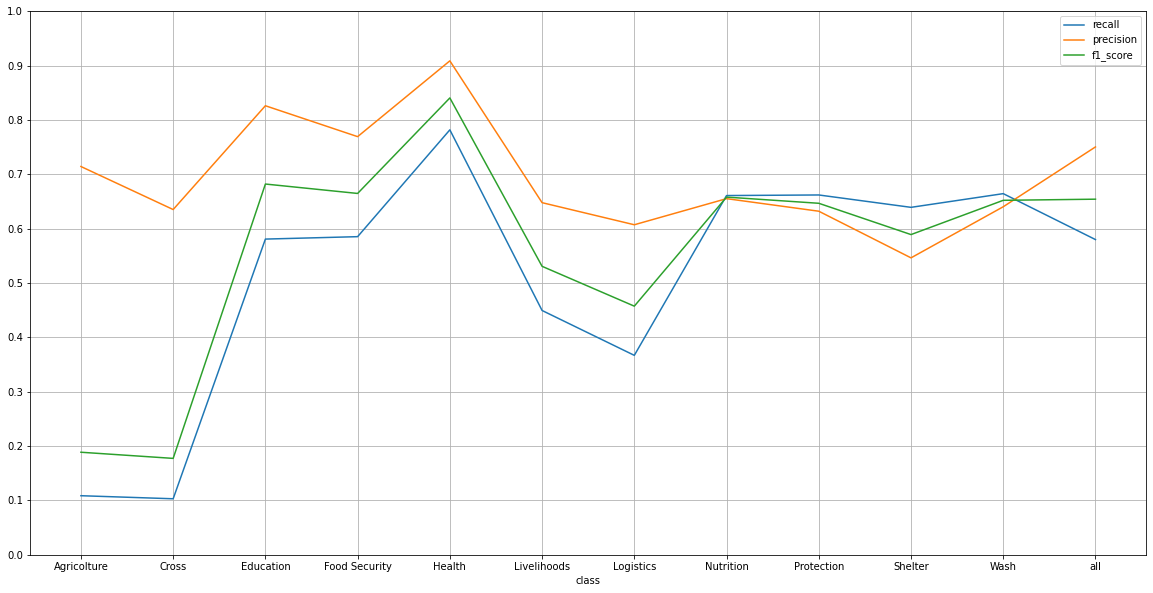

In [130]:
multi_label_metrics.plot(figsize=(20, 10), xticks=range(12), yticks=[x/10 for x in range(11)], ylim=(0, 1), grid=True)

In [113]:
base = Path('/home/ec2-user/SageMaker/experiments-dfs/models/fastai/results')

In [114]:
with open(base / 'weighted_multi_label.pickle', 'wb') as f:
    pickle.dump(multi_label_metrics, f)